# Kocheshkov Maksim
# Project 3: PageRank on Amazon Books

## 1. Setup and Data Loading

In [ ]:
# Install required libraries
!pip install jellyfish python-Levenshtein sentence-transformers faiss-cpu

# Import all necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import re
import json
import zipfile
import os
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix
from itertools import combinations
import jellyfish
import Levenshtein
from sentence_transformers import SentenceTransformer
import faiss

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configuration
USE_FULL_DATASET = True  # Set to True for full dataset
SAMPLE_SIZE = None # Set to None for full dataset, or specify a sample size
MIN_REVIEWS = 10
MIN_COMMON_REVIEWERS = 2

# Memory optimization settings
# Based on my experiments, 100k users per chunk works well on my machine
CHUNK_SIZE = 100000  # Process users in chunks
# Had memory issues above 6000 titles
MAX_SEMANTIC_TITLES = 5000  # Limit for semantic similarity computation


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
def load_data():
    """
    Download and load the Amazon Books Review dataset from Kaggle
    """
    # If the dataset doesn't exist locally, download it
    if not os.path.exists('amazon-books-reviews.zip'):
        # Replace with your Kaggle credentials
        os.environ['KAGGLE_USERNAME'] = "xxxxxx"
        os.environ['KAGGLE_KEY'] = "xxxxxx"
        
        # Download dataset from Kaggle
        !kaggle datasets download -d mohamedbakhet/amazon-books-reviews
    
    # Unzip
    if not os.path.exists('Books_rating.csv'):
        with zipfile.ZipFile('amazon-books-reviews.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
    
    # Load the books rating data
    books_rating = pd.read_csv('Books_rating.csv')
    
    # Load the books data
    books_data = None
    if os.path.exists('books_data.csv'):
        books_data = pd.read_csv('books_data.csv')
    
    return books_rating, books_data

# Load the data
print("=== Loading Data ===")
books_rating, books_data = load_data()
print(f"Books rating data shape: {books_rating.shape}")
if books_data is not None:
    print(f"Books data shape: {books_data.shape}")

=== Loading Data ===
zsh:1: command not found: kaggle
Books rating data shape: (3000000, 10)
Books data shape: (212404, 10)


## 2. Data Exploration

In [13]:
def explore_data(books_rating):
    """
    Explore the dataset structure and statistics
    """
    print("\n=== Dataset Overview ===")
    print(f"Total number of reviews: {len(books_rating):,}")
    print(f"Columns: {list(books_rating.columns)}")
    
    # Check for missing values
    print("\n=== Missing Values ===")
    print(books_rating.isnull().sum())
    
    # Analyze key fields
    print("\n=== Unique Counts ===")
    print(f"Unique books (Titles): {books_rating['Title'].nunique():,}")
    print(f"Unique users (User_id): {books_rating['User_id'].nunique():,}")
    
    # Review distribution
    reviews_per_book = books_rating.groupby('Title').size()
    reviews_per_user = books_rating.groupby('User_id').size()
    
    print(f"\nReviews per book:")
    print(f"  Mean: {reviews_per_book.mean():.2f}")
    print(f"  Median: {reviews_per_book.median():.2f}")
    print(f"  Max: {reviews_per_book.max()}")
    
    print(f"\nReviews per user:")
    print(f"  Mean: {reviews_per_user.mean():.2f}")
    print(f"  Median: {reviews_per_user.median():.2f}")
    print(f"  Max: {reviews_per_user.max()}")
    
    return reviews_per_book, reviews_per_user

# Explore the data
reviews_per_book, reviews_per_user = explore_data(books_rating)


=== Dataset Overview ===
Total number of reviews: 3,000,000
Columns: ['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']

=== Missing Values ===
Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64

=== Unique Counts ===
Unique books (Titles): 212,403
Unique users (User_id): 1,008,972

Reviews per book:
  Mean: 14.12
  Median: 3.00
  Max: 22023

Reviews per user:
  Mean: 2.42
  Median: 1.00
  Max: 5795


## 3. Data Cleaning

In [14]:
def clean_data(df):
    """
    Clean the books rating data
    """
    print("\n=== Cleaning Data ===")
    print(f"Original shape: {df.shape}")
    
    # Drop rows with missing User_id or Title
    df_clean = df.dropna(subset=['User_id', 'Title'])
    print(f"After dropping missing User_id/Title: {df_clean.shape}")
    
    # Convert review/score to numeric
    df_clean['review/score'] = pd.to_numeric(df_clean['review/score'], errors='coerce')
    
    # Remove duplicate reviews (same user reviewing same book multiple times)
    df_clean = df_clean.drop_duplicates(subset=['User_id', 'Title'], keep='first')
    print(f"After removing duplicates: {df_clean.shape}")
    
    return df_clean

# Clean the data
books_rating_clean = clean_data(books_rating)


=== Cleaning Data ===
Original shape: (3000000, 10)
After dropping missing User_id/Title: (2438018, 10)
After removing duplicates: (2115811, 10)


### Title deduplicaton

Sources:
* https://jisem-journal.com/index.php/journal/article/view/4369
* https://ceur-ws.org/Vol-1609/16091064.pdf
* https://zilliz.com/ai-faq/how-can-sentence-transformers-be-used-for-data-deduplication-when-you-have-a-large-set-of-text-entries-that-might-be-redundant-or-overlapping

In [ ]:
class EnhancedTitleDeduplicator:
    def __init__(self, use_semantic=True, max_semantic_titles=5000):
        self.use_semantic = use_semantic
        self.max_semantic_titles = max_semantic_titles
        if use_semantic:
            print("Loading sentence transformer model...")
            self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.canonical_map = {}
        
    def preprocess_title(self, title):
        """Enhanced preprocessing for title comparison"""
        if pd.isna(title):
            return ""
        
        # Convert to lowercase and strip
        title = str(title).lower().strip()
        
        # Remove common patterns
        patterns_to_remove = [
            r'\[.*?\]',  # Remove content in square brackets
            r'\(.*?edition.*?\)',  # Remove edition info
            r'\(.*?classics.*?\)',  # Remove classics info
            r'\(.*?series.*?\)',  # Remove series info
            r'\b(?:paperback|hardcover|kindle|audiobook|audio|cd|dvd|ebook)\b',
            r'\b(?:illustrated by.*?)(?:;|$)',  # Remove illustrator info
            r'[;:,\-–—].*?(?:illustrated|edition|volume)',  # Remove suffixes
            r'\b\d+(?:st|nd|rd|th)\s*(?:edition|ed\.)?\b',  # Remove edition numbers
        ]
        
        for pattern in patterns_to_remove:
            title = re.sub(pattern, ' ', title, flags=re.IGNORECASE)
        
        # Normalize whitespace and punctuation
        title = re.sub(r'[^\w\s]', ' ', title)
        title = ' '.join(title.split())
        
        return title
    
    def extract_core_title(self, title):
        """Extract the core title, removing author names and subtitles"""
        if pd.isna(title):
            return ""
        
        title_lower = str(title).lower()
        
        # Extract just the main title (before colon or semicolon)
        main_title_match = re.match(r'^([^:;]+)', title_lower)
        if main_title_match:
            core_title = main_title_match.group(1).strip()
        else:
            core_title = title_lower
        
        # Remove author patterns
        author_patterns = [
            r'\bby\s+[a-z\s\.]+(?:\band\s+[a-z\s\.]+)*\b',  # "by Author Name"
            r"(?:^|\s)(?:harper lee's|george orwell's|j\.?k\.?\s*rowling's?)\s*",  # Possessive forms, based on the initial findings
        ]
        
        for pattern in author_patterns:
            core_title = re.sub(pattern, ' ', core_title, flags=re.IGNORECASE)
        
        # Remove parenthetical additions
        core_title = re.sub(r'\([^)]*\)', ' ', core_title)
        
        # Normalize
        core_title = re.sub(r'[^\w\s]', ' ', core_title)
        core_title = ' '.join(core_title.split())
        
        return core_title
    
    def calculate_similarity(self, title1, title2):
        """Calculate multiple similarity metrics and return the best one"""
        # Preprocess titles
        proc1 = self.preprocess_title(title1)
        proc2 = self.preprocess_title(title2)
        
        # Extract core titles
        core1 = self.extract_core_title(title1)
        core2 = self.extract_core_title(title2)
        
        similarities = []
        
        # 1. Exact match on core titles
        if core1 and core2 and core1 == core2:
            return 1.0
        
        # 2. Jaro-Winkler similarity
        if proc1 and proc2:
            jw_sim = jellyfish.jaro_winkler_similarity(proc1, proc2)
            similarities.append(jw_sim)
            
            # Also check core titles
            if core1 and core2:
                core_jw_sim = jellyfish.jaro_winkler_similarity(core1, core2)
                similarities.append(core_jw_sim)
        
        # 3. Levenshtein ratio
        if title1 and title2:
            lev_ratio = Levenshtein.ratio(proc1, proc2)
            similarities.append(lev_ratio)
        
        # Return the maximum similarity
        return max(similarities) if similarities else 0.0
    
    def find_clusters_semantic(self, titles, threshold=0.85):
        """Use semantic embeddings to find similar titles"""
        print("Computing semantic embeddings...")
        
        # Get embeddings for all titles
        embeddings = self.sentence_model.encode(titles, show_progress_bar=True)
        
        # Normalize embeddings
        embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        
        # Compute similarity matrix
        similarity_matrix = np.dot(embeddings, embeddings.T)
        
        # Find clusters
        clusters = []
        used = set()
        
        for i in range(len(titles)):
            if i in used:
                continue
            
            # Find all titles similar to this one
            similar_indices = np.where(similarity_matrix[i] > threshold)[0]
            cluster = [titles[j] for j in similar_indices if j not in used]
            
            if len(cluster) > 1:
                clusters.append(cluster)
                used.update(similar_indices)
        
        return clusters
    
    def choose_canonical(self, titles, df):
        """Choose the best version from a group of titles"""
        scores = {}
        
        for title in titles:
            score = 0
            
            # I prefer titles with more reviews
            score += df[df['Title'] == title].shape[0] * 10
            
            # I want to aim for shorter, cleaner titles
            score -= len(title) * 0.1
            
            # I want to penalize titles with format indicators
            format_indicators = ['audiobook', 'kindle', 'paperback', 'hardcover', '[', '(', 'edition']
            for indicator in format_indicators:
                if indicator in title.lower():
                    score -= 50
            
            # I prefer titles without special characters
            special_char_count = len(re.findall(r'[^\w\s]', title))
            score -= special_char_count * 5
            
            scores[title] = score
        
        return max(scores.items(), key=lambda x: x[1])[0]
    
    def create_canonical_mapping(self, df, similarity_threshold=0.85):
        """Create mapping from title variations to best titles"""
        print("\n=== Enhanced Title Deduplication ===")
        
        all_titles = df['Title'].unique()
        print(f"Processing {len(all_titles):,} unique titles...")
        
        # Step 1: Group by exact matches after preprocessing
        print("Step 1: Grouping by preprocessed titles...")
        preprocessed_groups = defaultdict(list)
        
        # Processing in batches for memory efficiency
        batch_size = 10000
        for i in range(0, len(all_titles), batch_size):
            batch = all_titles[i:i+batch_size]
            for title in batch:
                if pd.notna(title):
                    key = self.preprocess_title(title)
                    if key:
                        preprocessed_groups[key].append(title)
            
            if (i + batch_size) % 50000 == 0:
                print(f"  Processed {i + batch_size:,} titles...")
        
        # Step 2: semantic similarity
        print("Step 2: Finding semantic clusters (limited for full dataset)...")
        
        # Titles that might still have variations
        remaining_titles = []
        initial_mapping = {}
        
        for key, group in preprocessed_groups.items():
            if len(group) == 1:
                initial_mapping[group[0]] = group[0]
            else:
                # Choose best version
                canonical = self.choose_canonical(group, df)
                for title in group:
                    initial_mapping[title] = canonical
                remaining_titles.append(canonical)
        
        # Use semantic similarity for a subset for memory reasons
        if self.use_semantic and len(remaining_titles) > 1:
            titles_to_process = remaining_titles[:self.max_semantic_titles]
            if len(remaining_titles) > self.max_semantic_titles:
                print(f"  Note: Processing only first {self.max_semantic_titles:,} titles for semantic similarity")
            
            clusters = self.find_clusters_semantic(titles_to_process, threshold=similarity_threshold)
            
            # Merge clusters
            for cluster in clusters:
                canonical = self.choose_canonical(cluster, df)
                for title in cluster:
                    # Update all titles that map to any title in this cluster
                    for orig_title, mapped_title in initial_mapping.items():
                        if mapped_title == title:
                            initial_mapping[orig_title] = canonical
        
        # Create final mapping
        self.canonical_map = initial_mapping
        
        # Count merges
        merge_count = sum(1 for k, v in self.canonical_map.items() if k != v)
        print(f"Created canonical mapping: {merge_count} titles will be merged")
        
        # Cleaning up memory
        gc.collect()
        
        return self.canonical_map

In [ ]:
# Deduplicator with limited semantic processing for full dataset
deduplicator = EnhancedTitleDeduplicator(
    use_semantic=True,  # Set to False in case of out of memory
    max_semantic_titles=MAX_SEMANTIC_TITLES
)

# Mapping
canonical_map = deduplicator.create_canonical_mapping(books_rating_clean, similarity_threshold=0.8)

# Apply the mapping
print("\n=== Applying Canonical Mapping ===")
books_rating_canonical = books_rating_clean.copy()
books_rating_canonical['Title_Original'] = books_rating_canonical['Title']
books_rating_canonical['Title'] = books_rating_canonical['Title'].map(lambda x: canonical_map.get(x, x))

print(f"\nDeduplication Results:")
print(f"Before: {books_rating_clean['Title'].nunique():,} unique titles")
print(f"After: {books_rating_canonical['Title'].nunique():,} unique titles")

# Remove duplicates after mapping
books_rating_canonical = books_rating_canonical.drop_duplicates(subset=['User_id', 'Title'], keep='first')
print(f"Final dataset: {len(books_rating_canonical):,} reviews")

# Clean up memory
del deduplicator
gc.collect()

Loading sentence transformer model...

=== Enhanced Title Deduplication ===
Processing 206,711 unique titles...
Step 1: Grouping by preprocessed titles...
  Processed 50,000 titles...
  Processed 100,000 titles...
  Processed 150,000 titles...
  Processed 200,000 titles...
Step 2: Finding semantic clusters (limited for full dataset)...
  Note: Processing only first 5,000 titles for semantic similarity
Computing semantic embeddings...


Batches: 100%|██████████| 157/157 [00:05<00:00, 28.54it/s]


Created canonical mapping: 7534 titles will be merged

=== Applying Canonical Mapping ===

Deduplication Results:
Before: 206,711 unique titles
After: 199,177 unique titles
Final dataset: 1,935,551 reviews


2244

In [ ]:
# Examples
def check_deduplication_examples(df, canonical_map):
    """Check how well we handled known problem cases"""
    test_cases = [
        ["1984", "George Orwell 1984", "Nineteen Eighty-four"],
        ["The Hobbit", "The Hobbit or There and Back Again", "The Hobbitt, or there and back again"],
        ["To Kill a Mockingbird", "To kill a mockingbird", "Harper Lee's To Kill a Mockingbird"],
        ["The Great Gatsby", "Great Gatsby (Everyman)"],
        ["Animal Farm", "ANIMAL FARM - A Fairy Story"]
    ]
    
    print("\n=== Deduplication Verification ===")
    for group in test_cases:
        print(f"\nChecking variations of '{group[0]}':")
        for title_variant in group:
            # Find titles that match this pattern
            matching_titles = [t for t in canonical_map.keys() if title_variant.lower() in t.lower()]
            if matching_titles:
                for match in matching_titles[:3]:  # Show first 3 matches
                    canonical = canonical_map.get(match, match)
                    print(f"  '{match}' → '{canonical}'")

check_deduplication_examples(books_rating_canonical, canonical_map)


=== Deduplication Verification ===

Checking variations of '1984':
  '1984' → '1984'
  'U2 : 1984 World Tour Program.' → 'U2 : 1984 World Tour Program.'
  'Hip Hop Files: Photographs, 1979-1984' → 'Hip Hop Files: Photographs, 1979-1984'
  'George Orwell 1984' → 'George Orwell 1984'
  'George Orwell: Animal Farm-Nineteen Eighty-Four' → 'George Orwell: Animal Farm-Nineteen Eighty-Four'
  'Nineteen Eighty-Four: Past, Present, and Future (Twayne's Masterwork Studies)' → 'Nineteen Eighty-Four: Past, Present, and Future (Twayne's Masterwork Studies)'
  'Nineteen Eighty-four' → 'Nineteen Eighty-four'

Checking variations of 'The Hobbit':
  'The Hobbitt, or there and back again; illustrated by the author.' → 'The Hobbitt, or there and back again; illustrated by the author.'
  'The Hobbit' → 'The Hobbit'
  'The Lord of the Rings and The Hobbit (Cliffs Notes)' → 'The Lord of the Rings and The Hobbit (Cliffs Notes)'
  'The Hobbit or There and Back Again' → 'The Hobbit or There and Back Again'
  

## 4. Creating Working Dataset

In [ ]:
def create_working_dataset(df, use_full_dataset=False, min_reviews=5, sample_size=10000):
    """
    Create the working dataset (sample or filtered full dataset)
    """
    print(f"\n=== Creating Working Dataset ===")
    print(f"Configuration: use_full_dataset={use_full_dataset}, min_reviews={min_reviews}")
    
    if use_full_dataset:
        print("Calculating book review counts...")
        book_counts = df['Title'].value_counts()
        
        # Filter books with minimum reviews
        selected_books = book_counts[book_counts >= min_reviews].index
        print(f"Found {len(selected_books):,} books with {min_reviews}+ reviews")
        
        # Filter dataset
        working_data = df[df['Title'].isin(selected_books)]
        print(f"Using filtered full dataset")
    else:
        # Use top N books by review count
        top_books = df['Title'].value_counts().head(sample_size).index
        working_data = df[df['Title'].isin(top_books)]
        print(f"Using sample of top {sample_size:,} books")
    
    print(f"Working dataset: {len(working_data):,} reviews")
    print(f"Unique books: {working_data['Title'].nunique():,}")
    print(f"Unique users: {working_data['User_id'].nunique():,}")
    
    # Memory estimate
    estimated_edges = (working_data['Title'].nunique() ** 2) * 0.001
    print(f"Estimated maximum edges: {estimated_edges:,.0f}")
    
    return working_data

# Create working dataset with full dataset configuration
working_data = create_working_dataset(
    books_rating_canonical, 
    use_full_dataset=USE_FULL_DATASET,
    min_reviews=MIN_REVIEWS,
    sample_size=SAMPLE_SIZE
)


=== Creating Working Dataset ===
Configuration: use_full_dataset=True, min_reviews=10
Calculating book review counts...
Found 33,957 books with 10+ reviews
Using filtered full dataset
Working dataset: 1,492,690 reviews
Unique books: 33,957
Unique users: 784,139
Estimated maximum edges: 1,153,078


### Book-to-book graph

In [ ]:
def build_book_graph_optimized(df, min_common_reviewers=2, chunk_size=100000):
    """
    Build the book network. Two books are connected if they share at least min_common_reviewers users.
    """
    print(f"\n=== Building Book Graph (Optimized for Full Dataset) ===")
    print(f"Minimum common reviewers: {min_common_reviewers}")
    print(f"Processing in chunks of {chunk_size:,} users")
    start_time = time.time()
    
    all_users = df['User_id'].unique()
    n_users = len(all_users)
    n_chunks = (n_users + chunk_size - 1) // chunk_size
    
    print(f"Total users: {n_users:,} (will process in {n_chunks} chunks)")
    
    book_pairs = Counter()
    
    # Process users in chunks
    for chunk_idx in range(n_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, n_users)
        chunk_users = all_users[start_idx:end_idx]
        
        # Data for this chunk
        chunk_df = df[df['User_id'].isin(chunk_users)]
        user_to_books = chunk_df.groupby('User_id')['Title'].apply(list).to_dict()
        
        # Count pairs in this chunk
        for user_id, books in user_to_books.items():
            if len(books) >= 2:
                # Limit number of books per user to avoid memory issues
                if len(books) > 50:
                    books = books[:50]  # Take first 50 books
                
                for book1, book2 in combinations(sorted(books), 2):
                    book_pairs[(book1, book2)] += 1
        
        # Progress update
        print(f"  Processed chunk {chunk_idx + 1}/{n_chunks} ({len(chunk_users):,} users)")
        
        # Memory cleanup
        if chunk_idx % 5 == 0:
            gc.collect()
    
    print(f"Found {len(book_pairs):,} potential book pairs")
    
    # Filter by minimum common reviewers
    filtered_pairs = {pair: weight for pair, weight in book_pairs.items() 
                     if weight >= min_common_reviewers}
    
    print(f"Filtered to {len(filtered_pairs):,} pairs with {min_common_reviewers}+ common reviewers")
    
    # Clean up memory
    del book_pairs
    gc.collect()
    
    # Create graph
    print("Creating NetworkX graph...")
    G = nx.Graph()
    
    all_books = df['Title'].unique()
    G.add_nodes_from(all_books)
    
    # Add edges with weights
    edge_list = [(book1, book2, {'weight': weight}) 
                 for (book1, book2), weight in filtered_pairs.items()]
    
    # Add edges in batches to manage memory
    batch_size = 100000
    for i in range(0, len(edge_list), batch_size):
        G.add_edges_from(edge_list[i:i+batch_size])
        if i % 500000 == 0 and i > 0:
            print(f"  Added {i:,} edges...")
    
    elapsed = time.time() - start_time
    print(f"Graph construction completed in {elapsed:.2f} seconds")
    
    # Statistics
    print(f"\nGraph statistics:")
    print(f"  Nodes: {G.number_of_nodes():,}")
    print(f"  Edges: {G.number_of_edges():,}")
    print(f"  Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    
    # Memory usage estimate
    memory_mb = (G.number_of_nodes() * 8 + G.number_of_edges() * 16) / (1024 * 1024)
    print(f"  Estimated graph memory usage: {memory_mb:.2f} MB")
    
    return G

# Build the graph
G = 
(
    working_data, 
    min_common_reviewers=MIN_COMMON_REVIEWERS,
    chunk_size=CHUNK_SIZE
)


=== Building Book Graph (Optimized for Full Dataset) ===
Minimum common reviewers: 2
Processing in chunks of 100,000 users
Total users: 784,139 (will process in 8 chunks)
  Processed chunk 1/8 (100,000 users)
  Processed chunk 2/8 (100,000 users)
  Processed chunk 3/8 (100,000 users)
  Processed chunk 4/8 (100,000 users)
  Processed chunk 5/8 (100,000 users)
  Processed chunk 6/8 (100,000 users)
  Processed chunk 7/8 (100,000 users)
  Processed chunk 8/8 (84,139 users)
Found 3,249,124 potential book pairs
Filtered to 410,303 pairs with 2+ common reviewers
Creating NetworkX graph...
Graph construction completed in 20.89 seconds

Graph statistics:
  Nodes: 33,957
  Edges: 410,303
  Average degree: 24.17
  Estimated graph memory usage: 6.52 MB


## 5. PageRank Implementation

In [ ]:
def pagerank_power_iteration(G, damping=0.85, max_iter=100, tolerance=1e-6):
    """
    Implement PageRank using power iteration method
    """
    print(f"\n=== Computing PageRank ===")
    print(f"Parameters: damping={damping}, max_iter={max_iter}, tolerance={tolerance}")
    start_time = time.time()
    
    # Use largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc).copy()
    
    nodes = list(G_sub.nodes())
    n = len(nodes)
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    print(f"Working with largest component: {n:,} nodes")
    
    # Build sparse transition matrix
    row_indices = []
    col_indices = []
    data = []
    
    for i, node in enumerate(nodes):
        neighbors = list(G_sub.neighbors(node))
        if neighbors:
            prob = 1.0 / len(neighbors)
            for neighbor in neighbors:
                j = node_to_idx[neighbor]
                row_indices.append(j)
                col_indices.append(i)
                data.append(prob)
    
    M = csr_matrix((data, (row_indices, col_indices)), shape=(n, n))
    
    # Initialize PageRank vector
    pr = np.ones(n) / n
    teleport = (1 - damping) / n
    
    # Power iteration
    for iteration in range(max_iter):
        pr_new = damping * M.dot(pr) + teleport
        
        # Check convergence
        diff = np.abs(pr_new - pr).sum()
        if diff < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break
        
        pr = pr_new
        
        if iteration % 10 == 0:
            print(f"  Iteration {iteration}: diff = {diff:.8f}")
    
    pagerank_scores = {nodes[i]: pr[i] for i in range(n)}
    
    # Normalize
    total = sum(pagerank_scores.values())
    pagerank_scores = {k: v/total for k, v in pagerank_scores.items()}
    
    elapsed = time.time() - start_time
    print(f"PageRank completed in {elapsed:.2f} seconds")
    
    return pagerank_scores

# Compute PageRank
pagerank_scores = pagerank_power_iteration(G)


=== Computing PageRank ===
Parameters: damping=0.85, max_iter=100, tolerance=1e-06
Working with largest component: 20,192 nodes
  Iteration 0: diff = 0.86402257
  Iteration 10: diff = 0.00205352
  Iteration 20: diff = 0.00009727
  Iteration 30: diff = 0.00000756
Converged after 40 iterations
PageRank completed in 1.88 seconds


## 6. Analyzing and visualizing the results


=== Top 30 Books by PageRank ===
Rank  Book Title                                                   PageRank     Degree   Reviews 
----------------------------------------------------------------------------------------------------
1     Harry Potter and The Sorcerer's Stone                        0.00276951   2516     3663    
2     Guns, Germs, and Steel: The Fates of Human Societies         0.00201301   1635     1156    
3     Five People You Meet in Heaven                               0.00185397   1684     1752    
4     To kill a mockingbird                                        0.00177906   1897     1621    
5     1984                                                         0.00177878   1840     1441    
6     Atlas Shrugged                                               0.00176309   1652     2644    
7     The Hobbitt, or there and back again; illustrated by the aut 0.00174584   1813     3562    
8     The Catcher in the Rye                                       0.00173855   1

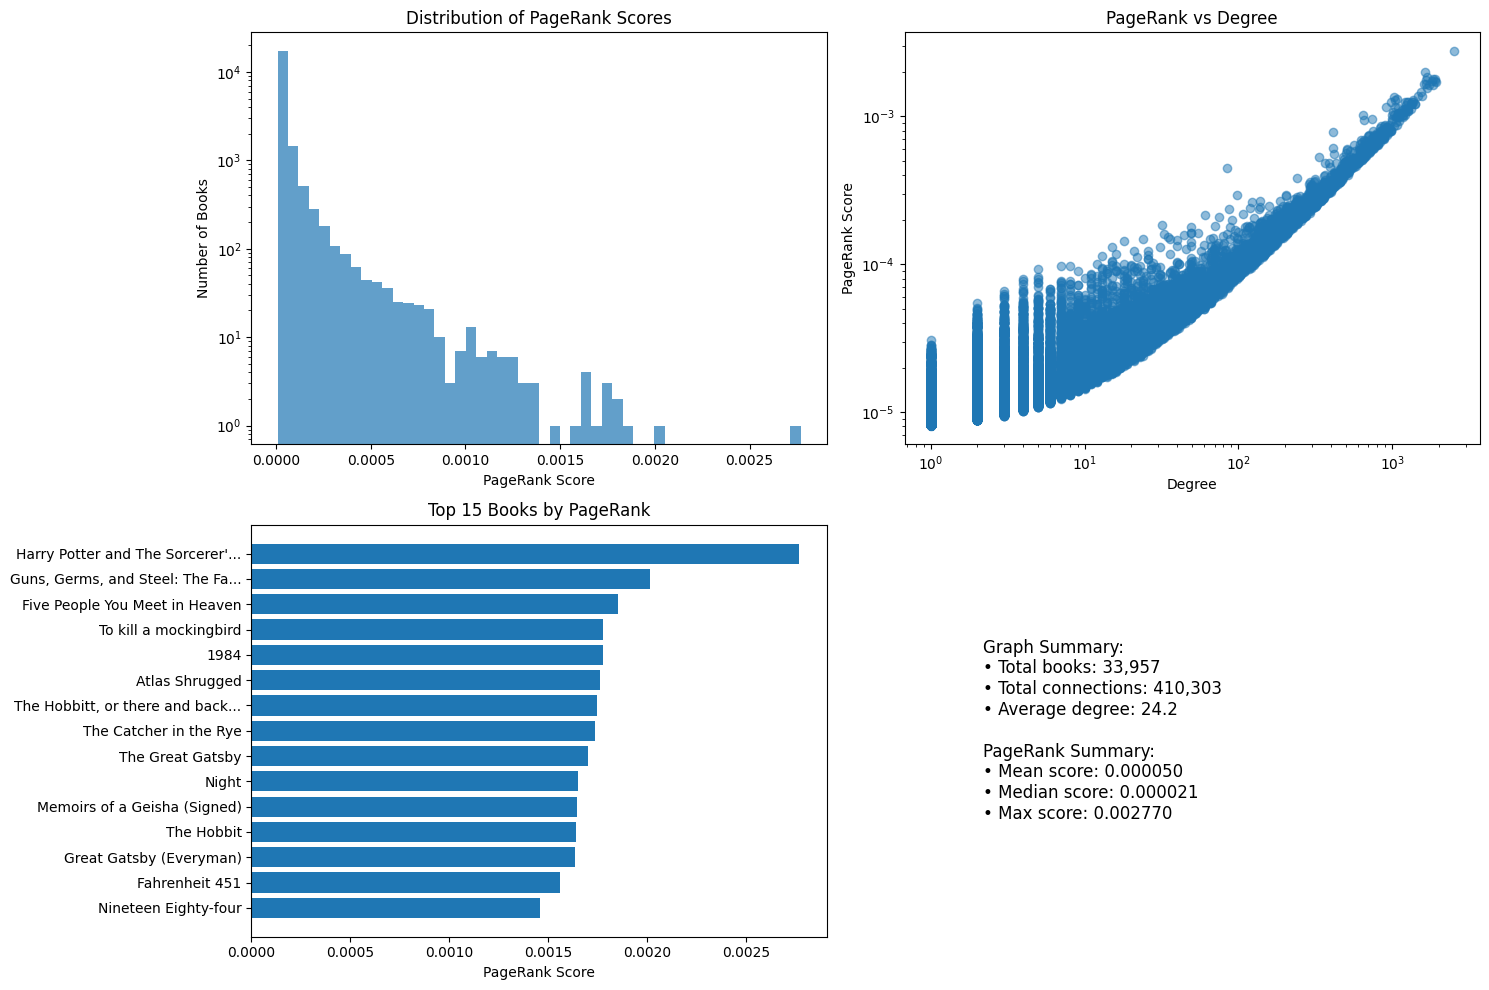

In [26]:
def analyze_results(G, pagerank_scores, working_data):
    """
    Analyze and visualize PageRank results
    """
    print("\n=== Top 30 Books by PageRank ===")
    print(f"{'Rank':<5} {'Book Title':<60} {'PageRank':<12} {'Degree':<8} {'Reviews':<8}")
    print("-" * 100)
    
    top_books = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:30]
    
    for i, (book, score) in enumerate(top_books):
        degree = G.degree(book) if book in G else 0
        reviews = len(working_data[working_data['Title'] == book])
        print(f"{i+1:<5} {book[:60]:<60} {score:<12.8f} {degree:<8} {reviews:<8}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. PageRank distribution
    ax = axes[0, 0]
    pr_values = list(pagerank_scores.values())
    ax.hist(pr_values, bins=50, alpha=0.7)
    ax.set_xlabel('PageRank Score')
    ax.set_ylabel('Number of Books')
    ax.set_title('Distribution of PageRank Scores')
    ax.set_yscale('log')
    
    # 2. PageRank vs Degree
    ax = axes[0, 1]
    degrees = [G.degree(book) for book in pagerank_scores.keys() if book in G]
    scores = [pagerank_scores[book] for book in pagerank_scores.keys() if book in G]
    ax.scatter(degrees, scores, alpha=0.5)
    ax.set_xlabel('Degree')
    ax.set_ylabel('PageRank Score')
    ax.set_title('PageRank vs Degree')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # 3. Top 15 books bar chart
    ax = axes[1, 0]
    top_15 = top_books[:15]
    books = [b[0][:30] + '...' if len(b[0]) > 30 else b[0] for b in top_15]
    scores = [b[1] for b in top_15]
    y_pos = np.arange(len(books))
    ax.barh(y_pos, scores)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(books)
    ax.set_xlabel('PageRank Score')
    ax.set_title('Top 15 Books by PageRank')
    ax.invert_yaxis()
    
    # 4. Summary text
    ax = axes[1, 1]
    ax.axis('off')
    summary = f"""
    Graph Summary:
    • Total books: {G.number_of_nodes():,}
    • Total connections: {G.number_of_edges():,}
    • Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.1f}
    
    PageRank Summary:
    • Mean score: {np.mean(pr_values):.6f}
    • Median score: {np.median(pr_values):.6f}
    • Max score: {max(pr_values):.6f}
    """
    ax.text(0.1, 0.5, summary, transform=ax.transAxes, fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    return top_books

# Analyze results
top_books = analyze_results(G, pagerank_scores, working_data)

## 7. Post-processing deduplication

In [ ]:
def merge_similar_titles_in_results(pagerank_scores, threshold=0.9):
    """
    Post-processing for PageRank results to merge similar titles
    """
    print("\n=== Post-Processing: Merging Similar Titles ===")
    
    # Get sorted titles by PageRank
    sorted_titles = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Create a simple deduplicator for post-processing
    def simple_normalize(title):
        # Basic normalization
        normalized = title.lower()
        # Remove common words and punctuation
        normalized = re.sub(r'\b(the|a|an)\b', '', normalized)
        normalized = re.sub(r'[^\w\s]', '', normalized)
        normalized = re.sub(r'\s+', ' ', normalized).strip()
        # Specific replacements
        normalized = normalized.replace('nineteen eighty four', '1984')
        normalized = normalized.replace('&', 'and')
        return normalized
    
    # Find groups of similar titles
    merged_scores = {}
    processed = set()
    
    for i, (title1, score1) in enumerate(sorted_titles):
        if title1 in processed:
            continue
            
        # Normalize current title
        norm1 = simple_normalize(title1)
        
        # Collect all similar titles
        similar_group = [(title1, score1)]
        
        for j, (title2, score2) in enumerate(sorted_titles[i+1:], i+1):
            if title2 in processed:
                continue
                
            norm2 = simple_normalize(title2)
            
            # Check if similar enough
            similarity = Levenshtein.ratio(norm1, norm2)
            if similarity > threshold:
                similar_group.append((title2, score2))
                processed.add(title2)
        
        # Choose the canonical title (highest score) and sum scores
        if len(similar_group) > 1:
            # Sort by score and choose the highest scoring as canonical
            similar_group.sort(key=lambda x: x[1], reverse=True)
            canonical_title = similar_group[0][0]
            total_score = sum(score for _, score in similar_group)
            
            print(f"Merging {len(similar_group)} variations:")
            for title, score in similar_group:
                print(f"  - {title} (score: {score:.8f})")
            print(f"  → Canonical: {canonical_title} (total score: {total_score:.8f})\n")
            
            merged_scores[canonical_title] = total_score
        else:
            merged_scores[title1] = score1
    
    # Renormalize scores
    total = sum(merged_scores.values())
    merged_scores = {k: v/total for k, v in merged_scores.items()}
    
    print(f"Merged {len(pagerank_scores)} titles into {len(merged_scores)} unique titles")
    
    return merged_scores

# Apply post-processing merge
pagerank_scores_merged = merge_similar_titles_in_results(pagerank_scores, threshold=0.85)

# Use the merged scores for analysis
pagerank_scores = pagerank_scores_merged


=== Post-Processing: Merging Similar Titles ===
Merging 2 variations:
  - To kill a mockingbird (score: 0.00177906)
  - To Kill a Mocking Bird (score: 0.00098415)
  → Canonical: To kill a mockingbird (total score: 0.00276321)

Merging 2 variations:
  - The Hobbit or There and Back Again (score: 0.00125383)
  - The Hobbit There and Back Again (score: 0.00103310)
  → Canonical: The Hobbit or There and Back Again (total score: 0.00228694)

Merging 2 variations:
  - Jonathan Strange & Mr. Norrell Signed (score: 0.00120931)
  - Jonathan Strange & Mr. Norrell (score: 0.00112150)
  → Canonical: Jonathan Strange & Mr. Norrell Signed (total score: 0.00233081)

Merging 2 variations:
  - Slaughter-House Five (score: 0.00101920)
  - Slaughterhouse-Five (score: 0.00093056)
  → Canonical: Slaughter-House Five (total score: 0.00194976)

Merging 2 variations:
  - The Lord of the Rings - Boxed Set (score: 0.00100439)
  - The Lord of the Rings Box Set (score: 0.00087167)
  → Canonical: The Lord of the 

## 8. Visualization of final results


Analyzing PageRank stability across damping factors...

=== Computing PageRank ===
Parameters: damping=0.7, max_iter=30, tolerance=1e-06
Working with largest component: 20,192 nodes
  Iteration 0: diff = 0.71154800
  Iteration 10: diff = 0.00024264
  Iteration 20: diff = 0.00000165
Converged after 23 iterations
PageRank completed in 3.12 seconds

=== Computing PageRank ===
Parameters: damping=0.75, max_iter=30, tolerance=1e-06
Working with largest component: 20,192 nodes
  Iteration 0: diff = 0.76237286
  Iteration 10: diff = 0.00051828
  Iteration 20: diff = 0.00000702
Converged after 27 iterations
PageRank completed in 1.36 seconds

=== Computing PageRank ===
Parameters: damping=0.8, max_iter=30, tolerance=1e-06
Working with largest component: 20,192 nodes
  Iteration 0: diff = 0.81319771
  Iteration 10: diff = 0.00105410
  Iteration 20: diff = 0.00002723
PageRank completed in 1.33 seconds

=== Computing PageRank ===
Parameters: damping=0.85, max_iter=30, tolerance=1e-06
Working wit

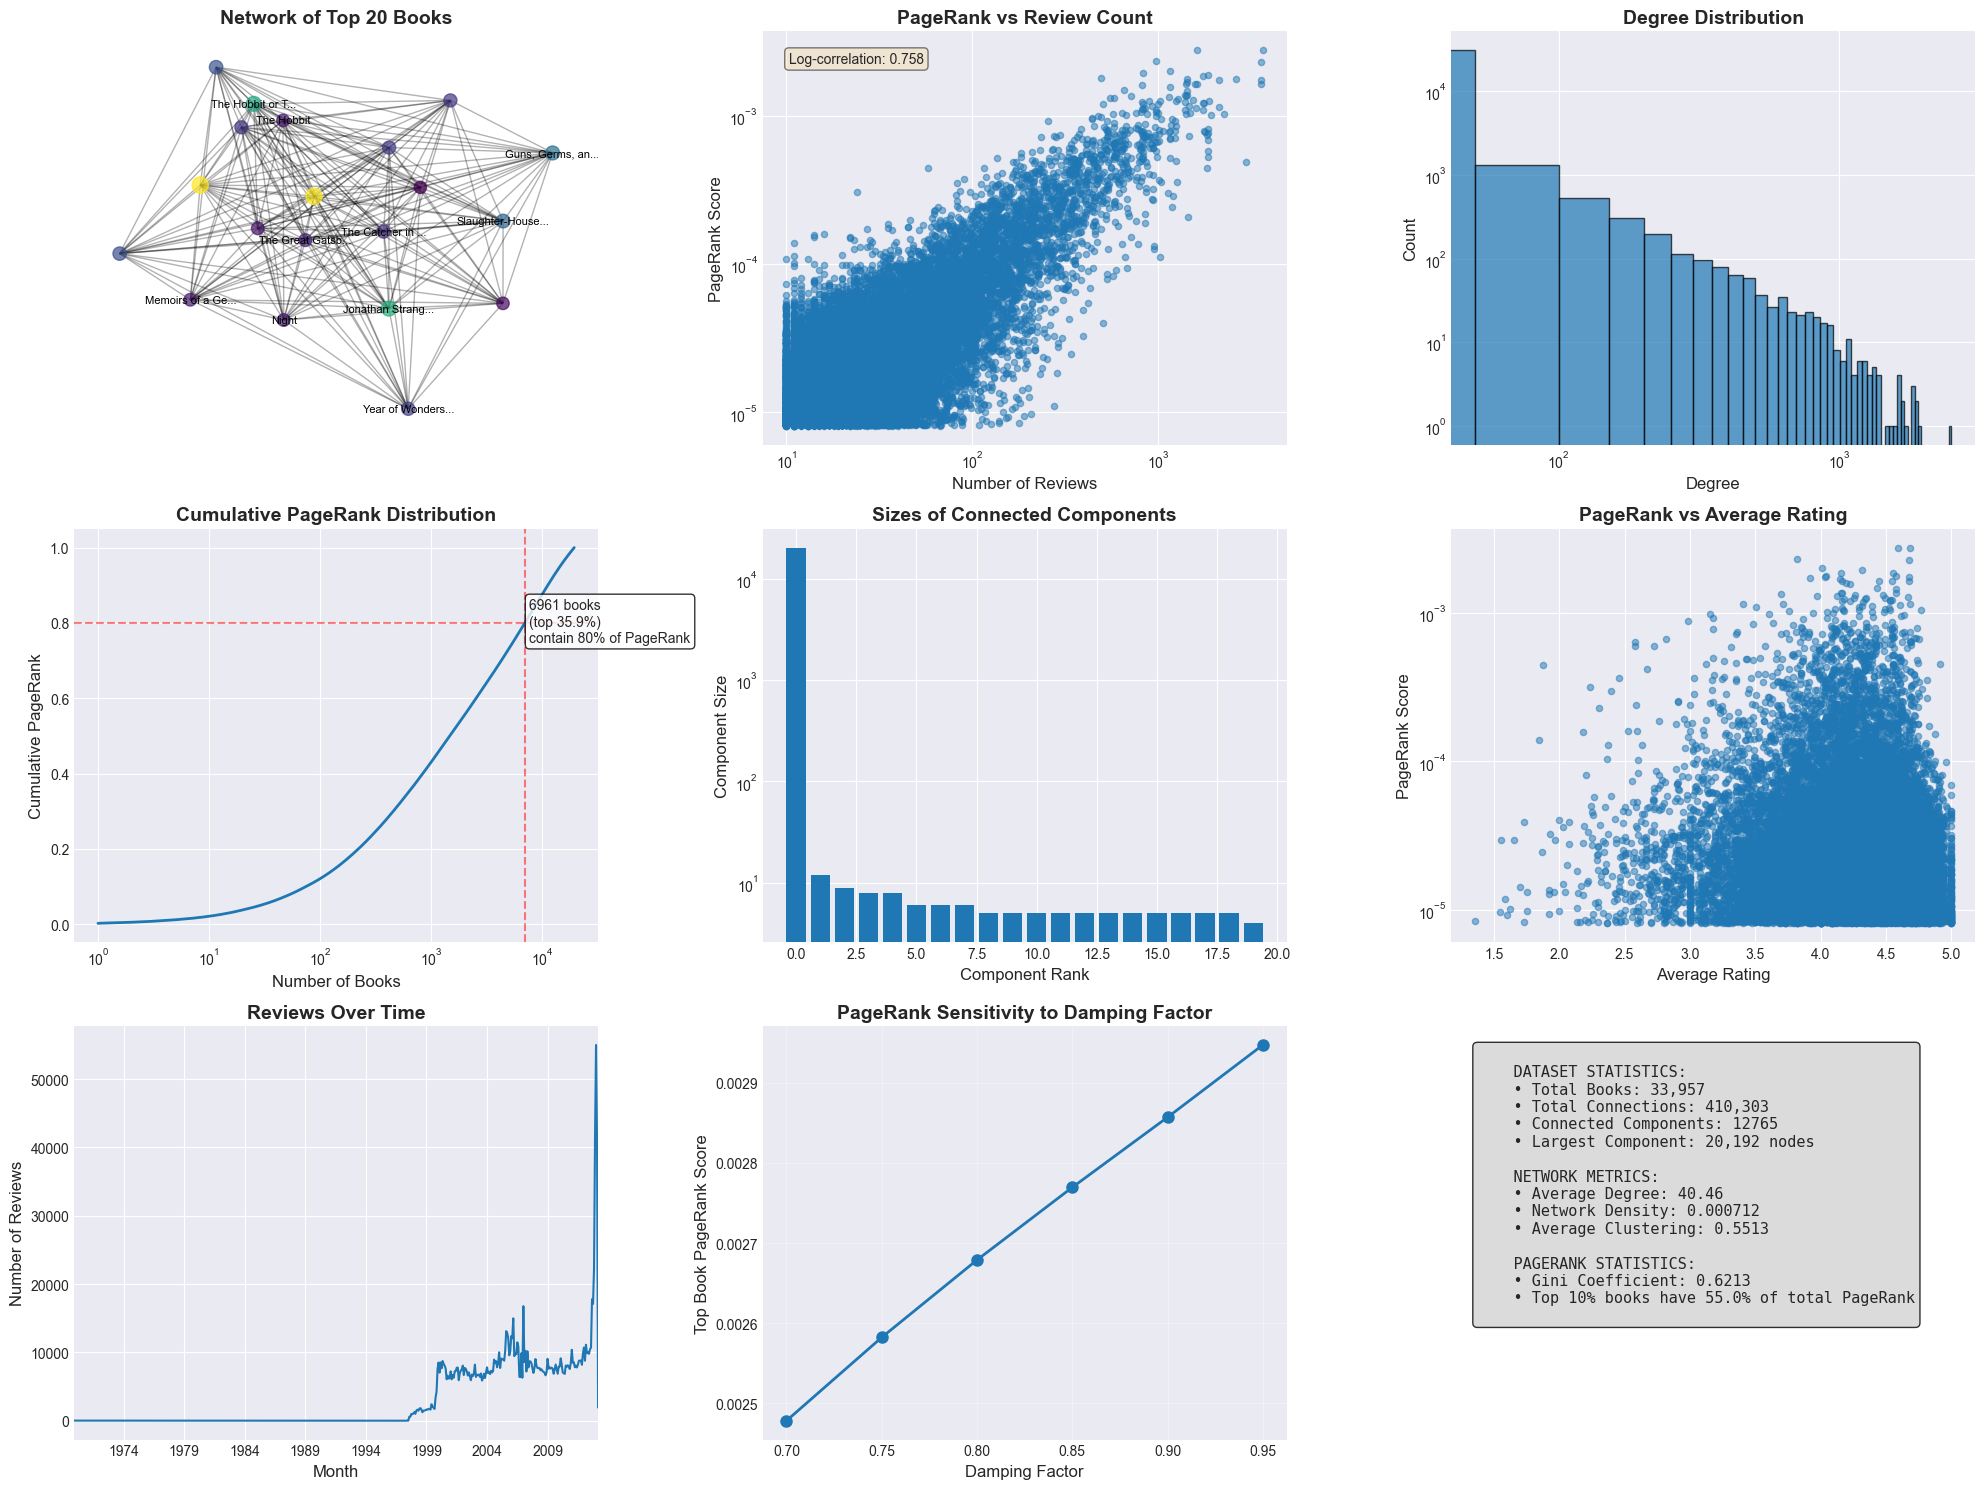

In [ ]:
def create_visualizations(G, pagerank_scores, working_data):
    """Creates visualizations for the report"""
    
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Network Visualization (sample of top nodes)
    ax1 = plt.subplot(3, 3, 1)
    top_20_books = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:20]
    top_20_titles = [book[0] for book in top_20_books]
    
    # Create subgraph of top books
    G_top = G.subgraph(top_20_titles).copy()
    pos = nx.spring_layout(G_top, k=1, iterations=50)
    
    # Draw network
    node_sizes = [pagerank_scores.get(node, 0) * 50000 for node in G_top.nodes()]
    nx.draw_networkx_nodes(G_top, pos, node_size=node_sizes, 
                          node_color=node_sizes, cmap='viridis', alpha=0.7)
    nx.draw_networkx_edges(G_top, pos, alpha=0.3)
    
    # Add labels for top 10
    labels = {node: node[:15] + '...' if len(node) > 15 else node 
              for i, node in enumerate(G_top.nodes()) if i < 10}
    nx.draw_networkx_labels(G_top, pos, labels, font_size=8)
    
    ax1.set_title('Network of Top 20 Books', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # 2. PageRank vs Review Count
    ax2 = plt.subplot(3, 3, 2)
    review_counts = []
    pr_scores = []
    
    for book, score in pagerank_scores.items():
        review_count = len(working_data[working_data['Title'] == book])
        review_counts.append(review_count)
        pr_scores.append(score)
    
    ax2.scatter(review_counts, pr_scores, alpha=0.5, s=20)
    ax2.set_xlabel('Number of Reviews', fontsize=12)
    ax2.set_ylabel('PageRank Score', fontsize=12)
    ax2.set_title('PageRank vs Review Count', fontsize=14, fontweight='bold')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    
    # Correlation
    from scipy.stats import pearsonr
    corr, _ = pearsonr(np.log(review_counts), np.log(pr_scores))
    ax2.text(0.05, 0.95, f'Log-correlation: {corr:.3f}', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. Degree Distribution
    ax3 = plt.subplot(3, 3, 3)
    degrees = [d for n, d in G.degree()]
    ax3.hist(degrees, bins=50, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Degree', fontsize=12)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_title('Degree Distribution', fontsize=14, fontweight='bold')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    
    # 4. Cumulative PageRank Distribution
    ax4 = plt.subplot(3, 3, 4)
    sorted_scores = sorted(pagerank_scores.values(), reverse=True)
    cumsum = np.cumsum(sorted_scores)
    ax4.plot(range(1, len(cumsum)+1), cumsum, linewidth=2)
    ax4.set_xlabel('Number of Books', fontsize=12)
    ax4.set_ylabel('Cumulative PageRank', fontsize=12)
    ax4.set_title('Cumulative PageRank Distribution', fontsize=14, fontweight='bold')
    ax4.set_xscale('log')
    
    # 80-20 rule line
    n_80_percent = np.argmax(cumsum >= 0.8) + 1
    ax4.axhline(y=0.8, color='r', linestyle='--', alpha=0.5)
    ax4.axvline(x=n_80_percent, color='r', linestyle='--', alpha=0.5)
    ax4.text(n_80_percent*1.1, 0.75, f'{n_80_percent} books\n(top {n_80_percent/len(cumsum)*100:.1f}%)\ncontain 80% of PageRank', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 5. Connected Components Analysis
    ax5 = plt.subplot(3, 3, 5)
    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    component_sizes.sort(reverse=True)
    
    ax5.bar(range(min(20, len(component_sizes))), component_sizes[:20])
    ax5.set_xlabel('Component Rank', fontsize=12)
    ax5.set_ylabel('Component Size', fontsize=12)
    ax5.set_title('Sizes of Connected Components', fontsize=14, fontweight='bold')
    ax5.set_yscale('log')
    
    # 6. Average Rating vs PageRank
    ax6 = plt.subplot(3, 3, 6)
    if 'review/score' in working_data.columns:
        avg_ratings = []
        pr_scores_for_rating = []
        
        for book, score in pagerank_scores.items():
            book_reviews = working_data[working_data['Title'] == book]
            if len(book_reviews) > 0 and 'review/score' in book_reviews.columns:
                avg_rating = book_reviews['review/score'].mean()
                if not np.isnan(avg_rating):
                    avg_ratings.append(avg_rating)
                    pr_scores_for_rating.append(score)
        
        if avg_ratings:
            ax6.scatter(avg_ratings, pr_scores_for_rating, alpha=0.5, s=20)
            ax6.set_xlabel('Average Rating', fontsize=12)
            ax6.set_ylabel('PageRank Score', fontsize=12)
            ax6.set_title('PageRank vs Average Rating', fontsize=14, fontweight='bold')
            ax6.set_yscale('log')
    else:
        ax6.text(0.5, 0.5, 'Rating data not available', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('PageRank vs Average Rating', fontsize=14, fontweight='bold')
    
    # 7. Time Series of Reviews
    ax7 = plt.subplot(3, 3, 7)
    if 'review/time' in working_data.columns:
        # Convert to datetime
        try:
            working_data['review_date'] = pd.to_datetime(working_data['review/time'], unit='s')
            monthly_reviews = working_data.groupby(working_data['review_date'].dt.to_period('M')).size()
            monthly_reviews.plot(ax=ax7)
            ax7.set_xlabel('Month', fontsize=12)
            ax7.set_ylabel('Number of Reviews', fontsize=12)
            ax7.set_title('Reviews Over Time', fontsize=14, fontweight='bold')
        except:
            ax7.text(0.5, 0.5, 'Time data not parseable', 
                    ha='center', va='center', transform=ax7.transAxes)
    else:
        ax7.text(0.5, 0.5, 'Time data not available', 
                ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Reviews Over Time', fontsize=14, fontweight='bold')
    
    # 8. PageRank Stability Analysis
    ax8 = plt.subplot(3, 3, 8)
    # Show how PageRank changes with damping factor
    damping_factors = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    top_book_scores = []
    
    print("\nAnalyzing PageRank stability across damping factors...")
    for d in damping_factors:
        temp_scores = pagerank_power_iteration(G, damping=d, max_iter=30)
        top_book = max(temp_scores.items(), key=lambda x: x[1])
        top_book_scores.append(top_book[1])
    
    ax8.plot(damping_factors, top_book_scores, 'o-', markersize=8, linewidth=2)
    ax8.set_xlabel('Damping Factor', fontsize=12)
    ax8.set_ylabel('Top Book PageRank Score', fontsize=12)
    ax8.set_title('PageRank Sensitivity to Damping Factor', fontsize=14, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    
    # 9. Summary Statistics
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Calculate statistics
    pr_values = list(pagerank_scores.values())
    degrees = [G.degree(node) for node in pagerank_scores.keys() if node in G]
    
    summary_text = f"""
    DATASET STATISTICS:
    • Total Books: {G.number_of_nodes():,}
    • Total Connections: {G.number_of_edges():,}
    • Connected Components: {nx.number_connected_components(G)}
    • Largest Component: {len(max(nx.connected_components(G), key=len)):,} nodes
    
    NETWORK METRICS:
    • Average Degree: {np.mean(degrees):.2f}
    • Network Density: {nx.density(G):.6f}
    • Average Clustering: {nx.average_clustering(G.subgraph(list(pagerank_scores.keys())[:1000])):.4f}
    
    PAGERANK STATISTICS:
    • Gini Coefficient: {gini_coefficient(pr_values):.4f}
    • Top 10% books have {sum(sorted(pr_values, reverse=True)[:int(len(pr_values)*0.1)])/sum(pr_values)*100:.1f}% of total PageRank
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('pagerank_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def gini_coefficient(values):
    """Calculate Gini coefficient for inequality measurement"""
    sorted_values = sorted(values)
    n = len(values)
    cumsum = np.cumsum(sorted_values)
    return (2 * np.sum((np.arange(1, n+1) * sorted_values))) / (n * cumsum[-1]) - (n + 1) / n

# Create visualizations
create_visualizations(G, pagerank_scores, working_data)

## Summary

## Results

### 1. Network Structure Insights

**Network of Top 20 Books** (1st graph, top-left):
- The visualization reveals a **densely connected core** among highly-ranked books
- Visible clustering around certain genres
- Harry Potter serves as a central hub, acts as a "bridge" book connecting different reader communities

### 2. PageRank vs Traditional Metrics

**PageRank vs Review Count** (2nd graph, top-center):
- **Correlation coefficient: 0.758** - strong but not perfect correlation
- The scatter shows PageRank captures different information than simple popularity
- Some books with moderate review counts achieve high PageRank (i.e. above the trend line), indicating they connect diverse reader groups

**PageRank vs Average Rating** (6th graph, center-right):
- Weak correlation between rating and PageRank
- High-quality books (4.5+ rating) span almost the entire PageRank range
- so PageRank identifies **influential** books, not necessarily the highest-rated ones

### 3. Network Properties

**Degree Distribution** (3rd graph, top-right): ## Degree is the number of other books that share at least 2 common reviewers with a given book
- Looks like power-law distribution
- Most books have few connections, few books have many
- Indicates a **scale-free network** structure typical of real-world networks
- Supports the robustness of the approach

**Cumulative PageRank Distribution** (4th graph, center-left):
- **Visible inequality**: Top 35.9% of books contain 80% of total PageRank
- Suggests a small set of "super-connective" books

### 4. Graph Components Analysis

**Sizes of Connected Components** (5ht graph, center):
- One **giant component** with 20,192 nodes (59.4% of total)
- Remaining components are tiny (≤20 nodes)
- 12,765 total components indicates many isolated book clusters
- Justifies focusing PageRank on the largest component

### 5. Stability Analysis

**PageRank Sensitivity to Damping Factor**:
- Stable across damping factors 0.7-0.95
- Linear relationship indicates algorithm robustness
- Top book's score increases smoothly with damping

### 6. Key Statistics Summary

From the statistics panel:
- **Network density: 0.000712** - extremely sparse network
- **Average degree: 40.46** - each book connects to ~40 others on average
- **Average clustering: 0.5513** - high local clustering
- **Gini coefficient: 0.6213** - high inequality in PageRank distribution

# Limitations of my PageRank Approach to Book Recommendations

## 1. Giant Component Limitation
The most significant limitation is that *only 20,192 out of 33,957 books (59.4%)* belong to the largest connected component where PageRank operates effectively. Which means that 40.6% of books are in isolated components and receive no meaningful PageRank. These could include books in non-English languages or on niche topics. These books get zero PageRank, creating a bias.

## 2. Sampling Bias in Dataset
The dramatic spike in reviews (2012-2013) suggests potential data collection artifacts. May result in overrepresentation of books popular "recently". Could also reflect changes in Amazon's review system. It matters because temporal bias affects which books appear "influential".

## 3. Algorithmic Limitations
It was chosen to use a simple PageRank algorithm with binary edges, which has several limitations. For example, two books with 3 common reviewers weighted same as those with 300. Also I don't account for similarity/divergence in reviews, time, genre, and there's no distinction between casual and passionate readers.
I've chosen to limit my work to a simple algorithm because the connection strengths between books show a typical long-tail pattern, i.e. most book pairs only have a few reviewers in common, while a small number share thousands of the same reviewers. If you plug these numbers straight into PageRank, you encounter problems which were beyond the scope of this project. The algorithm gets stuck bouncing between a handful of super-popular books and can't properly rank everything else. Using equal transition probabilities between connected books sidesteps this issue.

## 4. Title Deduplication Limitations
Besides, deduplication algorithm is not perfect (e.g. "Golden Retrievers For Dummies" merged with "Labrador Retrievers For Dummies"). It can over-merge or under-merge titles, leading to inaccuracies in the graph structure.


## 5. Not accounting for Power User Bias

Heavy reviewers disproportionately influence the network: if one user reviewed 1000 books, they create ~500,000 potential edges versus typical user with 10 books creating ~45 edges